# rACS in Real-Multiplexer

In [1]:
# Logger
import logging
logging.basicConfig(level=logging.INFO)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import local paths
import sys, os
sys.path.append(os.path.abspath('../../..'))
sys.path.append(os.path.abspath('../../../../openai-envs'))

# Enable automatic module reload
%load_ext autoreload
%autoreload 2

# Load PyALCS module
from lcs.representations.RealValueEncoder import RealValueEncoder
from lcs.agents.racs import RACS, Configuration

# Load OpenAI environments
import gym
import gym_multiplexer

## Real-Multiplexer
In 3-bit multiplexer first bit is responsible for addressing the correct answer.

> For testing purposes the last bit is used as a flag indicating if the action chosen by the algorithm was correct. The environment always introduces it with 0. It's value is changed to 1 if the action was chosen correctly.

In [2]:
# Environment initialization
rmpx = gym.make('real-multiplexer-3bit-v0')

rMPX acts like a normal MPX with the difference that instead on boolean values floating numbers within range `[0,1]` are used. Environment used internal threshold to transform them into boolean values (`threshold=0.5` is used as default).

In [3]:
state = rmpx.reset()
state

[0.810545883280684, 0.7985883164037659, 0.7730109069834438, 0]

Which corresponds to the following binary MPX:

In [4]:
threshold = 0.5  # secret knowledge
binary_state = map(lambda x: 1 if x > threshold else 0, state)

list(binary_state)

[1, 1, 1, 0]

Depending on the MPX size we have some actions to be executed. In 3-bit variant first bit (_address bit_) points to the correct answer (two possible values).

In [5]:
rmpx.action_space.n

2

We can also investigate the properties of a single observation (like vector dimension, lower and upper bound of each attribute).

In [6]:
print(f"Observation shape: {rmpx.observation_space.shape}")
print(f"Upper bounds: {rmpx.observation_space.low}")
print(f"Lower bounds: {rmpx.observation_space.high}")

Observation shape: (4,)
Upper bounds: [0. 0. 0. 0.]
Lower bounds: [1. 1. 1. 1.]


## rACS

- write abount _encoders_

In [7]:
def encode(bits, val):
    return int(RealValueEncoder(bits).encode(val))

r = np.arange(0, 1.1, .1)

df = pd.DataFrame(r, columns=['Perception'])

for bit in [1, 2, 3, 4, 5, 6, 7]:
    df[f'{bit}-bit'] = df.apply(lambda row: encode(bit, row['Perception']), axis=1)

df.set_index('Perception', inplace=True)
df

,1-bit,2-bit,3-bit,4-bit,5-bit,6-bit,7-bit
Perception,,,,,,,
0.0,0,0,0,0,0,0,0
0.1,0,0,1,2,3,6,13
0.2,0,1,1,3,6,13,25
0.3,0,1,2,5,9,19,38
0.4,0,1,3,6,12,25,51
0.5,0,2,4,8,16,32,64
0.6,1,2,4,9,19,38,76
0.7,1,2,5,11,22,44,89
0.8,1,2,6,12,25,50,102


## Experiment
In the experiment each attribute range will be represented as an _unorded bounded tuple_ with desired encoding resolution.

In [8]:
# We will use 6bit rmpx
rmpx = gym.make('real-multiplexer-6bit-v0')

ENCODER_BITS = 6

cfg = Configuration(rmpx.observation_space.shape[0], rmpx.action_space.n,
                    encoder=RealValueEncoder(ENCODER_BITS),
                    epsilon=1.0,  # exploration-exploitation ratio
                    do_ga=True,
                    theta_r=0.9,  # reliablity threshold
                    theta_i=0.2,  # inadequacy threshold
                    theta_ga=100,
                    chi=0.5,  # cross-over probability
                    mu=0.15)  # mutation probability

Initialize agent with no initial classifiers using configuration above.

In [9]:
agent = RACS(cfg)

Perform exploration for some trials

In [10]:
%%time

TRIALS = 20_000
population, metrics = agent.explore_exploit(rmpx, TRIALS)

INFO:lcs.agents.racs.RACS:{'agent': {'population': 1, 'numerosity': 1, 'reliable': 0, 'fitness': 25.0, 'cover_ratio': 0.8684807256235828, 'region_1': 0.0, 'region_2': 0.14285714285714285, 'region_3': 0.0, 'region_4': 0.8571428571428571, 'trial': 0, 'steps': 1, 'total_steps': 1}, 'environment': None, 'performance': {'reward': 1000}}
INFO:lcs.agents.racs.RACS:{'agent': {'population': 1721, 'numerosity': 1781, 'reliable': 0, 'fitness': 224.98659832406457, 'cover_ratio': 0.7000636396336531, 'region_1': 0.19589939404000997, 'region_2': 0.10849174068232754, 'region_3': 0.0020752054453390886, 'region_4': 0.6935336598323234, 'trial': 1000, 'steps': 1, 'total_steps': 1001}, 'environment': None, 'performance': {'reward': 0}}
INFO:lcs.agents.racs.RACS:{'agent': {'population': 3181, 'numerosity': 3350, 'reliable': 0, 'fitness': 227.49091438171743, 'cover_ratio': 0.6613694833482255, 'region_1': 0.2430951632460592, 'region_2': 0.10131584856514124, 'region_3': 0.002110746845107109, 'region_4': 0.6534

CPU times: user 6h 54min 6s, sys: 1min 15s, total: 6h 55min 22s
Wall time: 7h 1min 1s


During the process the algorithm is gathering metrics. Let's inspect the last one

In [11]:
metrics[-1]

{'agent': {'population': 19771,
  'numerosity': 22553,
  'reliable': 0,
  'fitness': 237.04223516935033,
  'cover_ratio': 0.6075300283483859,
  'region_1': 0.31703721901486304,
  'region_2': 0.08495848898458781,
  'region_3': 0.0047544383187496835,
  'region_4': 0.5932498536817995,
  'trial': 19999,
  'steps': 1,
  'total_steps': 20000},
 'environment': None,
 'performance': {'reward': 0}}

In [18]:
reliable = [cl for cl in population ]
reliable = sorted(reliable, key=lambda cl: -cl.fitness)

for cl in reliable[:10]:
    print(cl.condition)
    print(cl.effect)
    print(cl.q, cl.r, cl.exp, cl.num)
    print("\n")

OOOOOOOOOOO|OOOOOOOOOOO|OOOOOOOOOOO|...OO.....|OOOOOOOOOOO|...OO.....|.OO.......
OOOOOOOOOOO|OOOOOOOOOOO|OOOOOOOOOOO|OOOOOOOOOOO|OOOOOOOOOOO|OOOOOOOOOOO|........OOO
0.7561625104422353 806.8064574483574 15 5


OOOOOOOOOOO|OOOOOOOOOOO|OOOOOOOOOOO|OOOOOOOOOOO|........OO|OOOOOOOOOOO|.O........
OOOOOOOOOOO|OOOOOOOOOOO|OOOOOOOOOOO|OOOOOOOOOOO|OOOOOOOOOOO|OOOOOOOOOOO|.........OO
0.7155999538617702 834.2925862355269 12 8


..O.......|OOOOOOOOOOO|OOOOOOOOOOO|OOO.......|OOOOOOOOOOO|OOOOOOOOOOO|OO........
OOOOOOOOOOO|OOOOOOOOOOO|OOOOOOOOOOO|OOOOOOOOOOO|OOOOOOOOOOO|OOOOOOOOOOO|..........O
0.7154371979422351 825.2361311751746 5 1


OOOOOOOOOOO|OOOOOOOOOOO|..O.......|OOOOOOOOOOO|OOOOOOOOOOO|..OOO.....|O.........
OOOOOOOOOOO|OOOOOOOOOOO|OOOOOOOOOOO|OOOOOOOOOOO|OOOOOOOOOOO|OOOOOOOOOOO|.........OO
0.7541852378591615 775.3819532241926 7 2


OOOOOOOOOOO|......OOO.|OOOOOOOOOOO|OOOOOOOOOOO|OOOOOOOOOOO|OO........|OO........
OOOOOOOOOOO|OOOOOOOOOOO|OOOOOOOOOOO|OOOOOOOOOOO|OOOOOOOOOOO|OOOOOOOOOOO|..........O


In [13]:
def parse_metrics(metrics):
    lst = [[d['agent']['trial'], d['performance']['reward']] for d in metrics]

    df = pd.DataFrame(lst, columns=['trial', 'reward'])
    df = df.set_index('trial')

    return df

df = parse_metrics(metrics)
df['mode'] = df.index.map(lambda t: "explore" if t % 2 == 0 else "exploit")
df.head()

,reward,mode
trial,,
0,1000,explore
1,0,exploit
2,0,explore
3,0,exploit
4,0,explore


In [14]:
explore_df = df[df['mode'] == 'explore']
exploit_df = df[df['mode'] == 'exploit']

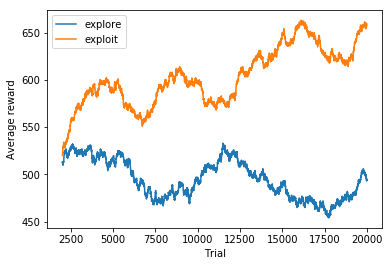

In [20]:
fig, ax = plt.subplots()
explore_df['reward'].rolling(window=500).mean().plot(label='explore', ax=ax)
exploit_df['reward'].rolling(window=500).mean().plot(label='exploit', ax=ax)

ax.set_xlabel('Trial')
ax.set_ylabel('Average reward')

plt.legend()
plt.show()